In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# https://hackanons.com/2020/12/python-extract-data-from-json-file.html
with open("json_files/heart_rate-2021-08-31.json") as f:
    json_data = json.load(f)

In [3]:
# https://www.geeksforgeeks.org/python-accessing-key-value-in-dictionary/
print ("Dict keys 1 are : ")
dict_keys1 = [k for k in json_data[0]]
print(dict_keys1)

values1 = [json_data[0][k] for k in json_data[0]]
print ("Dict keys 2 are : ")
dict_keys2 = [k for k in values1[1]]
print(dict_keys2)

print ("Values are : ")
values2 = [values1[1][k] for k in values1[1]]
print(values2)

# And then we are interested in values2[0]

heart_rate = np.zeros(len(json_data))

for i in range(len(json_data)):
    values1 = [json_data[i][k] for k in json_data[i]]
    values2 = [values1[1][k] for k in values1[1]]
    heart_rate[i] = values2[0]

Dict keys 1 are : 
['dateTime', 'value']
Dict keys 2 are : 
['bpm', 'confidence']
Values are : 
[61, 3]


In [7]:
def extract_hr(file_name):
    with open(file_name) as f:
        json_data = json.load(f)
    
    heart_rate = np.zeros(len(json_data))

    for i in range(len(json_data)):
        values1 = [json_data[i][k] for k in json_data[i]]
        values2 = [values1[1][k] for k in values1[1]]
        heart_rate[i] = values2[0]
        
    return heart_rate

In [10]:
heart_rate_31_8 = extract_hr("json_files/heart_rate-2021-08-31.json")
heart_rate_01_9 = extract_hr("json_files/heart_rate-2021-09-01.json")
heart_rate_02_9 = extract_hr("json_files/heart_rate-2021-09-02.json")

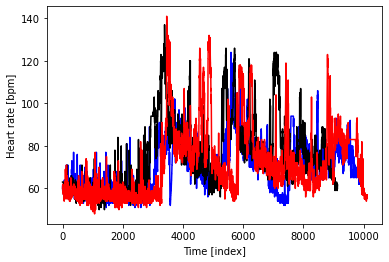

In [15]:
plt.plot(heart_rate_31_8, c="b")
plt.plot(heart_rate_01_9, c="k")
plt.plot(heart_rate_02_9, c="r")
plt.xlabel("Time [index]")
plt.ylabel("Heart rate [bpm]")
plt.show()